In [1]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
x_cell = np.loadtxt('./data/train_rc.txt')
x_tissue = np.loadtxt('./data/train_rt.txt')
x_hact =  np.loadtxt('./data/train_rh.txt')

y_cell = np.loadtxt('./data/train_answers_rc.txt')
y_tissue = np.loadtxt('./data/train_answers_rt.txt')
y_hact = np.loadtxt('./data/train_answers_rh.txt')

In [3]:
print(len(x_cell),len(x_tissue),len(x_hact))

56279 57810 54526


In [4]:
def equalizer(x_cell,y_cell):
    b,n,IS,IV = [],[],[],[]
    for values in range(len(x_cell)):
        if y_cell[values] == 0:
            n.append([x_cell[values], y_cell[values]])
        elif y_cell[values] == 1:
            b.append([x_cell[values], y_cell[values]])
        elif y_cell[values] == 2:
            IS.append([x_cell[values],y_cell[values]])
        else:
            IV.append([x_cell[values],y_cell[values]])
    print(len(b),len(n),len(IS),len(IV))
    min_len = min([len(b),len(n),len(IS),len(IV)])
    while len(b) != min_len:
        b.pop()
    while len(n) != min_len:
        n.pop()
    while len(IS) != min_len:
        IS.pop()
    while len(IV) != min_len:
        IV.pop()
    total = b + n + IS + IV
    x_cell = [values[0] for values in total]
    y_cell = [values[1] for values in total]
    print(len(b),len(n),len(IS),len(IV))
    return np.array(x_cell), np.array(y_cell)

In [5]:
x_cell, y_cell =equalizer(x_cell,y_cell)
print(len(x_cell),len(y_cell))
x_hact, y_hact = equalizer(x_hact,y_hact)
print(len(x_hact),len(y_hact))
x_tissue, y_tissue = equalizer(x_tissue,y_tissue)

14498 15378 13124 13279
13124 13124 13124 13124
52496 52496
13894 15069 12762 12801
12762 12762 12762 12762
51048 51048
14554 16734 13426 13096
13096 13096 13096 13096


In [6]:
def traingbm_find_best(train_data, test_data, objective,error,classes):
    param = {
        "objective": objective,
        "num_class": classes,
        "metric": error,
        "verbose": -1,
        "learning_rate": 0.1,
        "num_leaves": 191,
        "feature_fraction": 0.46,
        "bagging_fraction": 0.69,
        "bagging_freq": 0,
        "max_depth": 7,
        "device": "gpu",
        "gpu_platform_id":1,
        "gpu_device_id":0
    }
    evals = {}
    gbm = lgb.train(param, train_data,100,valid_sets=[test_data], callbacks = [lgb.record_evaluation(evals)])
    return evals
    


In [7]:
def svm_score(x_train,y_train,x_test,y_test):
    param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
    m = GridSearchCV(svm.SVC(), param_grid,refit = True, verbose = -1)
    m.fit(x_train,y_train)
    scores= m.predict(x_test)
    return classification_report(scores,y_test)

In [8]:
def log_score(x_train,y_train,x_test,y_test):
    param_grid = [
    {
     'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']}]
    m = GridSearchCV(LogisticRegression(), param_grid, cv = 5, verbose = True, n_jobs = -1)
    m.fit(x_train,y_train)
    score = m.predict(x_test)
    return classification_report(score,y_test)


In [9]:
def data_analysis(x,y):
    binary = []
    for i in range(len(y)):
        if y[i] == 0 or y[i] == 1:
            binary.append(0)
        else:
            binary.append(1)
    binary = np.array(binary)
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.1)
    x_bin_train, x_bin_test, y_bin_train, y_bin_test = train_test_split(x,binary,test_size = 0.1)
    train_data = lgb.Dataset(x_train, label=y_train)
    test_data = lgb.Dataset(x_test, label=y_test)
    bin_train_data  = lgb.Dataset(x_bin_train,label= y_bin_train)
    bin_test_data = lgb.Dataset(x_bin_test,label = y_bin_test)
    

    bestscores = {}
    print(len(x_train),len(set(y_train)),len(x_test),len(y_test))
    bestscores['gen_gbm'] = traingbm_find_best(train_data, test_data,'multiclass',["multi_logloss", "multi_error"],4)
    bestscores['bin_gbm'] = traingbm_find_best(bin_train_data, bin_test_data,'binary',['binary_logloss','binary_error'],1)

    bestscores['gen_svm'] = svm_score(x_train,y_train,x_test,y_test)
    bestscores['bin_svm'] = svm_score(x_bin_train, y_bin_train, x_bin_test, y_bin_test)

    bestscores['gen_log'] = log_score(x_train,y_train,x_test,y_test)
    bestscores['bin_log'] = log_score(x_bin_train, y_bin_train, x_bin_test, y_bin_test)

    return bestscores


In [10]:
hact = data_analysis(x_hact,y_hact)
print('hact complete!')

45943 4 5105 5105
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
hact complete!


In [11]:
cell = data_analysis(x_cell,y_cell)
print('cell complete!')

47246 4 5250 5250
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
cell complete!


In [12]:
tissue = data_analysis(x_tissue, y_tissue)
print('tissue complete!')

47145 4 5239 5239
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
tissue complete!


In [13]:
print(' ---------------- HACT RESULTS ---------------- ')

print('hact multiclass gbm:', min(hact['gen_gbm']['valid_0']['multi_logloss']))
print('hact binary gbm:', min(hact['bin_gbm']['valid_0']['binary_logloss']))


 ---------------- HACT RESULTS ---------------- 
hact multiclass gbm: 1.2293523389415077
hact binary gbm: 0.6359111203156174


In [14]:
print(' ---------------- CELL RESULTS ---------------- ')

print('cell multiclass gbm:', min(cell['gen_gbm']['valid_0']['multi_logloss']))
print('cell normal binary gbm:', min(cell['bin_gbm']['valid_0']['binary_logloss']))


 ---------------- CELL RESULTS ---------------- 
cell multiclass gbm: 1.0822844741081605
cell normal binary gbm: 0.5682360563224241


In [15]:
print(' ---------------- TISSUE RESULTS ---------------- ')

print('tissue multiclass gbm:', min(tissue['gen_gbm']['valid_0']['multi_logloss']))
print('tissue normal binary gbm:', min(tissue['bin_gbm']['valid_0']['binary_logloss']))

 ---------------- TISSUE RESULTS ---------------- 
tissue multiclass gbm: 1.2792587581532102
tissue normal binary gbm: 0.652892452302061


[0.616258570029383, 0.5982370225269343, 0.5894221351616062, 0.5849167482859942, 0.5837414299706171, 0.58256611165524, 0.5829578844270323, 0.5790401567091087, 0.5780607247796278, 0.574926542605289, 0.5809990205680705, 0.5806072477962781, 0.5819784524975514, 0.5808031341821743, 0.5780607247796278, 0.5759059745347699, 0.5761018609206661, 0.5766895200783545, 0.5737512242899119, 0.5768854064642507, 0.5766895200783545, 0.5776689520078354, 0.5776689520078354, 0.5778648383937316, 0.5741429970617042, 0.574926542605289, 0.5753183153770813, 0.5762977473065622, 0.5737512242899119, 0.5729676787463271, 0.5735553379040157, 0.5729676787463271, 0.5759059745347699, 0.5753183153770813, 0.5745347698334966, 0.5741429970617042, 0.5745347698334966, 0.5753183153770813, 0.574926542605289, 0.5737512242899119, 0.577277179236043, 0.5745347698334966, 0.5741429970617042, 0.5731635651322233, 0.5694417238001959, 0.5704211557296768, 0.5688540646425073, 0.5694417238001959, 0.5723800195886386, 0.569637610186092, 0.57198

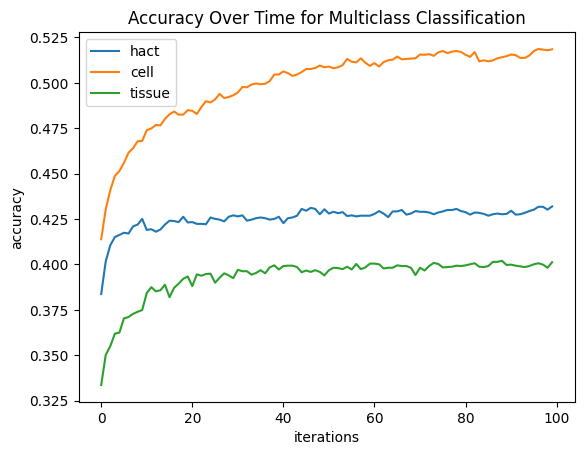

In [16]:
print(hact['gen_gbm']['valid_0']['multi_error'])
acc = []
for i in hact['gen_gbm']['valid_0']['multi_error']:
    acc.append(1-i)
plt.plot(range(len(acc)), acc, label = 'hact')
print(max(acc))

print(cell['gen_gbm']['valid_0']['multi_error'])
acc = []
for i in cell['gen_gbm']['valid_0']['multi_error']:
    acc.append(1-i)
plt.plot(range(len(acc)), acc, label = 'cell')
print(max(acc))
print(tissue['gen_gbm']['valid_0']['multi_error'])
acc = []
for i in tissue['gen_gbm']['valid_0']['multi_error']:
    acc.append(1-i)
plt.plot(range(len(acc)), acc, label = 'tissue')
print(max(acc))
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Accuracy Over Time for Multiclass Classification')
plt.legend()
plt.show()


[0.41214495592556316, 0.3952987267384917, 0.39255631733594515, 0.39138099902056805, 0.38374142997061705, 0.38472086190009797, 0.38511263467189033, 0.3892262487757101, 0.38863858961802156, 0.38374142997061705, 0.38276199804113614, 0.38276199804113614, 0.38158667972575905, 0.38178256611165523, 0.3794319294809011, 0.3794319294809011, 0.38178256611165523, 0.3811949069539667, 0.37982370225269346, 0.37982370225269346, 0.38001958863858964, 0.3794319294809011, 0.37786483839373164, 0.37668952007835454, 0.37277179236043095, 0.37179236043095004, 0.3743388834476004, 0.3712047012732615, 0.37179236043095004, 0.37042115572967677, 0.3714005876591577, 0.37296767874632714, 0.3714005876591577, 0.36904995102840354, 0.37042115572967677, 0.3700293829578844, 0.37159647404505386, 0.3735553379040157, 0.3751224289911851, 0.3751224289911851, 0.37277179236043095, 0.37081292850146913, 0.37042115572967677, 0.3698334965719883, 0.37061704211557295, 0.3682664054848188, 0.3686581782566112, 0.3714005876591577, 0.3682664

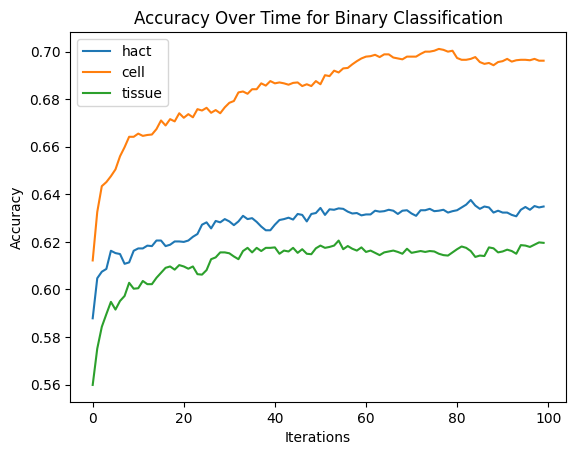

In [17]:
print(hact['bin_gbm']['valid_0']['binary_error'])
acc = []
for i in hact['bin_gbm']['valid_0']['binary_error']:
    acc.append(1-i)
plt.plot(range(len(acc)), acc, label = 'hact')
print(max(acc))

print(cell['bin_gbm']['valid_0']['binary_error'])
acc = []
for i in cell['bin_gbm']['valid_0']['binary_error']:
    acc.append(1-i)
plt.plot(range(len(acc)), acc, label = 'cell')
print(max(acc))
print(tissue['bin_gbm']['valid_0']['binary_error'])
acc = []
for i in tissue['bin_gbm']['valid_0']['binary_error']:
    acc.append(1-i)
plt.plot(range(len(acc)), acc, label = 'tissue')
print(max(acc))
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time for Binary Classification')
plt.legend()
plt.show()


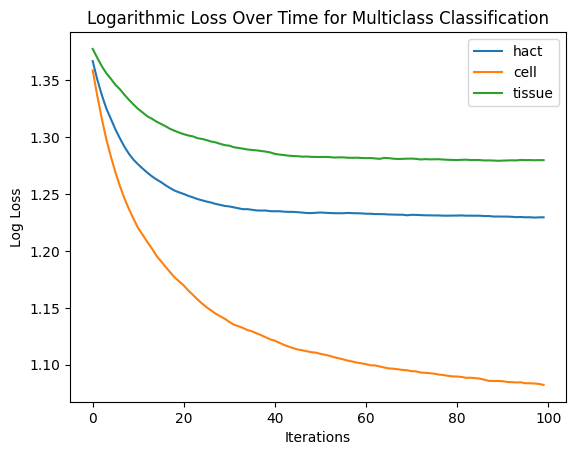

In [18]:
plt.plot(range(len(hact['gen_gbm']['valid_0']['multi_logloss'])), hact['gen_gbm']['valid_0']['multi_logloss'], label = 'hact')
plt.plot(range(len(cell['gen_gbm']['valid_0']['multi_logloss'])), cell['gen_gbm']['valid_0']['multi_logloss'], label = 'cell')
plt.plot(range(len(tissue['gen_gbm']['valid_0']['multi_logloss'])), tissue['gen_gbm']['valid_0']['multi_logloss'], label = 'tissue')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('Logarithmic Loss Over Time for Multiclass Classification')
plt.legend()
plt.show()

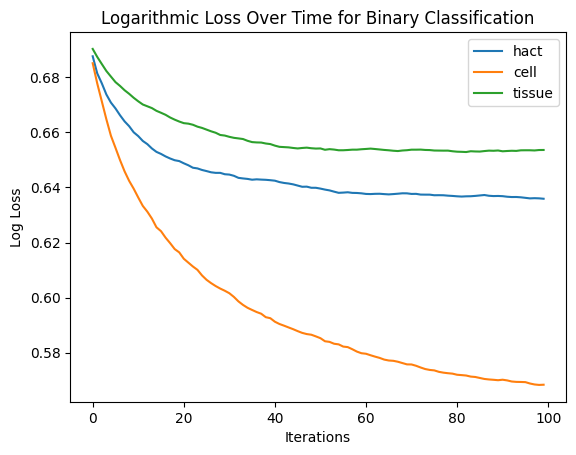

In [19]:
plt.plot(range(len(hact['bin_gbm']['valid_0']['binary_logloss'])), hact['bin_gbm']['valid_0']['binary_logloss'], label = 'hact')
plt.plot(range(len(cell['bin_gbm']['valid_0']['binary_logloss'])), cell['bin_gbm']['valid_0']['binary_logloss'], label = 'cell')
plt.plot(range(len(tissue['bin_gbm']['valid_0']['binary_logloss'])), tissue['bin_gbm']['valid_0']['binary_logloss'], label = 'tissue')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('Logarithmic Loss Over Time for Binary Classification')
plt.legend()
plt.show()

In [20]:
print(' ---------------- HACT RESULTS ---------------- ')
print('multiclass support vector classification')
print(hact['gen_svm'])
print('binary normal support vector classification')
print(hact['bin_svm'])

 ---------------- HACT RESULTS ---------------- 
multiclass support vector classification
              precision    recall  f1-score   support

         0.0       0.52      0.39      0.44      1648
         1.0       0.16      0.38      0.23       540
         2.0       0.44      0.42      0.43      1315
         3.0       0.64      0.52      0.57      1602

    accuracy                           0.44      5105
   macro avg       0.44      0.43      0.42      5105
weighted avg       0.50      0.44      0.46      5105

binary normal support vector classification
              precision    recall  f1-score   support

           0       0.67      0.62      0.64      2752
           1       0.59      0.65      0.62      2353

    accuracy                           0.63      5105
   macro avg       0.63      0.63      0.63      5105
weighted avg       0.64      0.63      0.63      5105



In [21]:
print(' ---------------- HACT RESULTS ---------------- ')
print('multiclass logistic regression')
print(hact['gen_log'])
print('binary normal logistic regression')
print(hact['bin_log'])

 ---------------- HACT RESULTS ---------------- 
multiclass logistic regression
              precision    recall  f1-score   support

         0.0       0.51      0.38      0.43      1657
         1.0       0.11      0.31      0.16       435
         2.0       0.44      0.40      0.42      1390
         3.0       0.63      0.51      0.56      1623

    accuracy                           0.42      5105
   macro avg       0.42      0.40      0.39      5105
weighted avg       0.49      0.42      0.45      5105

binary normal logistic regression
              precision    recall  f1-score   support

           0       0.67      0.60      0.63      2827
           1       0.56      0.64      0.60      2278

    accuracy                           0.62      5105
   macro avg       0.62      0.62      0.62      5105
weighted avg       0.62      0.62      0.62      5105



In [22]:
print(' ---------------- CELL RESULTS ---------------- ')
print('multiclass support vector classification')
print(cell['gen_svm'])
print('binary normal support vector classification')
print(cell['bin_svm'])

 ---------------- CELL RESULTS ---------------- 
multiclass support vector classification
              precision    recall  f1-score   support

         0.0       0.47      0.48      0.47      1267
         1.0       0.44      0.49      0.46      1212
         2.0       0.54      0.47      0.51      1502
         3.0       0.66      0.68      0.67      1269

    accuracy                           0.53      5250
   macro avg       0.53      0.53      0.53      5250
weighted avg       0.53      0.53      0.53      5250

binary normal support vector classification
              precision    recall  f1-score   support

           0       0.72      0.69      0.70      2699
           1       0.69      0.71      0.70      2551

    accuracy                           0.70      5250
   macro avg       0.70      0.70      0.70      5250
weighted avg       0.70      0.70      0.70      5250



In [23]:
print(' ---------------- CELL RESULTS ---------------- ')
print('multiclass logistic regression')
print(cell['gen_log'])
print('binary normal logistic regression')
print(cell['bin_log'])

 ---------------- CELL RESULTS ---------------- 
multiclass logistic regression
              precision    recall  f1-score   support

         0.0       0.34      0.43      0.38      1010
         1.0       0.22      0.38      0.28       765
         2.0       0.46      0.43      0.44      1410
         3.0       0.72      0.46      0.56      2065

    accuracy                           0.43      5250
   macro avg       0.44      0.42      0.42      5250
weighted avg       0.50      0.43      0.45      5250

binary normal logistic regression
              precision    recall  f1-score   support

           0       0.56      0.65      0.61      2240
           1       0.71      0.62      0.66      3010

    accuracy                           0.64      5250
   macro avg       0.64      0.64      0.63      5250
weighted avg       0.65      0.64      0.64      5250



In [24]:
print(' ---------------- TISSUE RESULTS ---------------- ')
print('multiclass support vector classification')
print(tissue['gen_svm'])
print('binary normal support vector classification')
print(tissue['bin_svm'])

 ---------------- TISSUE RESULTS ---------------- 
multiclass support vector classification
              precision    recall  f1-score   support

         0.0       0.50      0.39      0.44      1691
         1.0       0.18      0.35      0.24       682
         2.0       0.40      0.41      0.41      1301
         3.0       0.60      0.48      0.53      1565

    accuracy                           0.42      5239
   macro avg       0.42      0.41      0.40      5239
weighted avg       0.46      0.42      0.43      5239

binary normal support vector classification
              precision    recall  f1-score   support

           0       0.69      0.61      0.65      2996
           1       0.55      0.64      0.59      2243

    accuracy                           0.62      5239
   macro avg       0.62      0.62      0.62      5239
weighted avg       0.63      0.62      0.62      5239



In [25]:
print(' ---------------- TISSUE RESULTS ---------------- ')
print('multiclass logistic regression')
print(tissue['gen_log'])
print('binary normal logistic regression')
print(tissue['bin_log'])

 ---------------- TISSUE RESULTS ---------------- 
multiclass logistic regression
              precision    recall  f1-score   support

         0.0       0.40      0.37      0.38      1428
         1.0       0.18      0.32      0.23       740
         2.0       0.40      0.39      0.39      1355
         3.0       0.59      0.44      0.50      1716

    accuracy                           0.39      5239
   macro avg       0.39      0.38      0.38      5239
weighted avg       0.43      0.39      0.40      5239

binary normal logistic regression
              precision    recall  f1-score   support

           0       0.64      0.61      0.62      2754
           1       0.59      0.62      0.60      2485

    accuracy                           0.61      5239
   macro avg       0.61      0.61      0.61      5239
weighted avg       0.61      0.61      0.61      5239

